{
    "2CB": [
        6,
        8
    ],
    "3CB": [
        6,
        8,
        13
    ],
    "4CB": [
        1,
        6,
        8,
        13
    ],
    "7CB": [
        1,
        6,
        7,
        8,
        13,
        14,
        17
    ],
    "2CW": [
        0,
        2
    ],
    "3CW": [
        0,
        2,
        5
    ],
    "4CW": [
        13,
        15,
        16,
        17
    ],
    "7CW": [
        11,
        12,
        13,
        14,
        15,
        16,
        17
    ]
}

In [1]:
import numpy as np
import itertools
from scipy.stats import gaussian_kde
from tqdm import tqdm
import matplotlib.pyplot as plt

def calculate_kde(data):
    return gaussian_kde(data)

def calculate_kld(kde_p, kde_q, data_points, epsilon=1e-10):
    p = kde_p(data_points)
    q = kde_q(data_points)
    
    # Ensure no zero values
    p = np.maximum(p, epsilon)
    q = np.maximum(q, epsilon)
    
    return np.sum(p * np.log(p / q))


def generate_class_distance(kdes, class1, class2, epsilon=1e-10):
    kl_distance = 0
    for kde1, kde2 in zip(kdes[class1], kdes[class2]):
        data_points = np.linspace(min(kde1.dataset.min(), kde2.dataset.min()), max(kde1.dataset.max(), kde2.dataset.max()), 100)
        kl_distance += calculate_kld(kde1, kde2, data_points, epsilon)
        kl_distance += calculate_kld(kde2, kde1, data_points, epsilon)
    return kl_distance

def generate_class_distance_matrix(kdes, num_classes, epsilon=1e-10):
    distance_matrix = np.zeros((num_classes, num_classes))
    for i in tqdm(range(num_classes), desc="Class Distance Matrix Calculation"):
        for j in range(i + 1, num_classes):
            distance = generate_class_distance(kdes, i, j, epsilon)
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    return distance_matrix

def calculate_separability_score(combination, distance_matrix):
    score = 0
    for (i, j) in itertools.combinations(combination, 2):
        score += distance_matrix[i, j]
    return score

def calculate_distance_matrix(data, labels, num_classes, epsilon=1e-10, show_matrix=False, save_matrix_name=None):
    kdes = {cls: [] for cls in range(num_classes)}
    
    print("Calculating KDEs for each class...")
    for cls in tqdm(range(num_classes), desc="Classes"):
        if len(data[labels == cls]) == 0:
            continue
        else:
            for i in range(data.shape[1]):
                kde = calculate_kde(data[labels == cls,i,:].reshape(-1))
                kdes[cls].append(kde)

    
    print("Generating class distance matrix using KLD...")
    distance_matrix = generate_class_distance_matrix(kdes, num_classes, epsilon)
    if save_matrix_name is not None:
        np.save(f"distance_matrix_{save_matrix_name}.npy", distance_matrix)
    if show_matrix:
        
        # Generate heatmap
        plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')

        # Add colorbar
        plt.colorbar()

        # Add title and labels
        plt.title('Distance Matrix Heatmap')
        plt.xlabel('Class')
        plt.ylabel('Class')

        # Show the plot
        plt.show()
    
    return distance_matrix

def calculate_separability_scores(distance_matrix, num_classes, n):

    class_combinations = itertools.combinations(range(num_classes), n)
    separability_scores = []
    print("Calculating final separability scores...")
    for combination in tqdm(class_combinations, desc="Combinations"):
        score = calculate_separability_score(combination, distance_matrix)
        separability_scores.append((combination, score))
    
    separability_scores.sort(key=lambda x: x[1], reverse=True)
    
    top_combinations = separability_scores[:10]
    for comb, score in top_combinations:
        print(f"Combination: {comb}, Score: {score}")
    
    return separability_scores

def distance_matrix_subset(distance_matrix, subset):
    subset_matrix = np.zeros((len(subset), len(subset)))
    for i in range(len(subset)):
        for j in range(i, len(subset)):
            subset_matrix[i, j] = distance_matrix[subset[i], subset[j]]
            subset_matrix[j, i] = distance_matrix[subset[j], subset[i]]
    
    plt.imshow(subset_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Distance Matrix Heatmap')
    plt.xlabel('Class')
    plt.ylabel('Class')
    plt.show()

    return subset_matrix

(6,)
(6,)
ytrain shape (55404, 18)
yval shape (18468, 18)
ytest shape (18469, 18)
num classes train dataset: 18 occurrences of each class:[3127 3066 2855 3205 3044 3092 3102 2981 3047 3150 3087 3058 3154 3095
 2973 3013 3142 3213]
num classes eval dataset: 18 occurrences of each class:[1035  968  935 1024 1048 1038 1122  982  996 1110 1053 1039 1066  966
 1007  979 1023 1077]
num classes test dataset: 18 occurrences of each class:[1046 1061  900 1045 1048 1029 1046  989 1036 1076 1026 1067 1014  965
  982 1049 1036 1054]
Calculating KDEs for each class...


Classes: 100%|██████████| 18/18 [00:00<00:00, 73.68it/s]


Generating class distance matrix using KLD...


Class Distance Matrix Calculation: 100%|██████████| 18/18 [12:14<00:00, 40.79s/it]


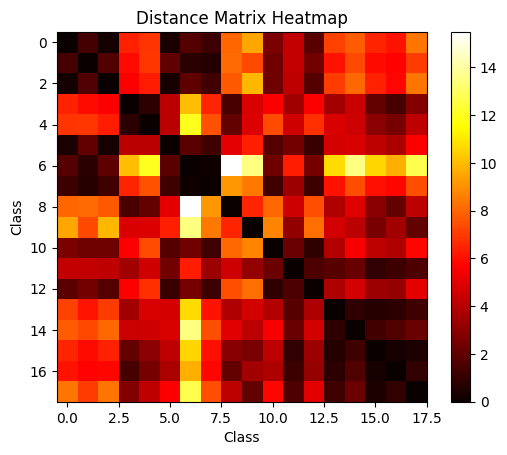

Calculating final separability scores...


Combinations: 153it [00:00, 1158354.71it/s]

Combination: (6, 8), Score: 15.473610499338053
Combination: (6, 9), Score: 13.503188273117434
Combination: (6, 14), Score: 13.50173411192306
Combination: (6, 17), Score: 12.711648129085674
Combination: (4, 6), Score: 12.020372021674834
Combination: (6, 13), Score: 10.714260970330884
Combination: (6, 15), Score: 10.609153936503548
Combination: (3, 6), Score: 10.040193790218005
Combination: (2, 9), Score: 9.891860594114553
Combination: (6, 16), Score: 9.701804743583363


In [2]:
import sys
sys.path.append('../src')
from networks_debug import *
from dataloader import WisdmDatasetParser, WisdmDataset
from torch.utils.data import  DataLoader
from pathlib import Path
from tqdm import tqdm

dataset = WisdmDatasetParser(f'{Path.home()}/snntorch_network/data/data_watch_subset_0_40.npz', norm=None)
train_set = dataset.get_training_set()

data, labels = train_set 
num_classes = 18
n = 2



[((6, 8), 15.473610499338053),
 ((6, 9), 13.503188273117434),
 ((6, 14), 13.50173411192306),
 ((6, 17), 12.711648129085674),
 ((4, 6), 12.020372021674834),
 ((6, 13), 10.714260970330884),
 ((6, 15), 10.609153936503548),
 ((3, 6), 10.040193790218005),
 ((2, 9), 9.891860594114553),
 ((6, 16), 9.701804743583363),
 ((0, 9), 9.535464703730804),
 ((7, 8), 9.176043539854257),
 ((9, 10), 8.73276197845376),
 ((7, 9), 8.439073893407684),
 ((2, 17), 8.377733859621419),
 ((0, 17), 8.351353704866023),
 ((9, 12), 8.201926141649022),
 ((1, 8), 8.112370752127646),
 ((2, 14), 8.075132383827714),
 ((8, 10), 8.06055027768185),
 ((0, 8), 8.02097049319963),
 ((0, 14), 7.782639239564708),
 ((2, 8), 7.702441823232917),
 ((4, 7), 7.530030745502038),
 ((8, 12), 7.483374135582427),
 ((7, 14), 7.458610612556751),
 ((7, 17), 7.447128620666317),
 ((4, 10), 7.427194951481526),
 ((1, 9), 7.361833355955687),
 ((1, 14), 7.3434262354205115),
 ((0, 13), 7.1893762565044055),
 ((1, 17), 7.051508628877849),
 ((2, 13), 7.03

Calculating KDEs for each class...


Classes: 100%|██████████| 18/18 [00:00<00:00, 104.88it/s]


Generating class distance matrix using KLD...


Class Distance Matrix Calculation: 100%|██████████| 18/18 [12:09<00:00, 40.55s/it]


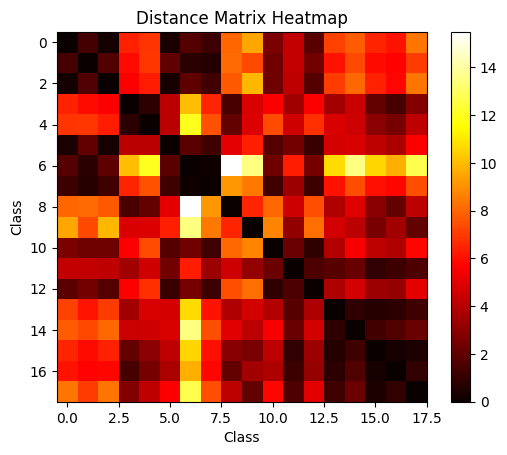

Calculating final separability scores...


Combinations: 31824it [00:00, 230773.34it/s]

Combination: (0, 2, 6, 8, 9, 14, 17), Score: 150.93521362323165
Combination: (0, 4, 6, 8, 9, 10, 14), Score: 150.29896282779436
Combination: (2, 4, 6, 8, 9, 10, 14), Score: 149.97353040704218
Combination: (0, 2, 4, 6, 8, 9, 14), Score: 149.74290149419437
Combination: (2, 4, 6, 7, 8, 9, 14), Score: 149.61196399839844
Combination: (0, 4, 6, 7, 8, 9, 14), Score: 149.4855091266457
Combination: (2, 4, 6, 8, 9, 14, 17), Score: 149.2628153141958
Combination: (0, 4, 6, 8, 9, 14, 17), Score: 149.2609289218063
Combination: (2, 6, 7, 8, 9, 14, 17), Score: 149.25754158025106
Combination: (0, 6, 7, 8, 9, 14, 17), Score: 148.50949664998907


[((0, 2, 6, 8, 9, 14, 17), 150.93521362323165), ((0, 4, 6, 8, 9, 10, 14), 150.29896282779436), ((2, 4, 6, 8, 9, 10, 14), 149.97353040704218), ((0, 2, 4, 6, 8, 9, 14), 149.74290149419437), ((2, 4, 6, 7, 8, 9, 14), 149.61196399839844), ((0, 4, 6, 7, 8, 9, 14), 149.4855091266457), ((2, 4, 6, 8, 9, 14, 17), 149.2628153141958), ((0, 4, 6, 8, 9, 14, 17), 149.2609289218063), ((2, 6, 7, 8, 9, 14, 17), 149.25754158025106), ((0, 6, 7, 8, 9, 14, 17), 148.50949664998907), ((2, 6, 8, 9, 10, 14, 17), 148.07627268307772), ((0, 6, 8, 9, 10, 14, 17), 147.78011504532066), ((4, 6, 7, 8, 9, 10, 14), 147.76028597303164), ((1, 2, 4, 6, 8, 9, 14), 147.655002001499), ((0, 4, 6, 8, 9, 13, 14), 147.57699685162913), ((1, 2, 6, 8, 9, 14, 17), 147.53848943951846), ((2, 4, 6, 8, 9, 13, 14), 147.39966368974012), ((0, 1, 4, 6, 8, 9, 14), 147.37109680314808), ((0, 2, 6, 8, 9, 13, 14), 147.3352325516623), ((0, 4, 6, 8, 9, 10, 17), 147.21369222411334), ((4, 6, 7, 8, 9, 14, 17), 147.16278854200925), ((0, 4, 6, 8, 9, 12, 

NameError: name 'distance_matrix' is not defined